## Phising Dataset

To collect the dataset, we have deployed multiple agents and soluble agents within an infrastructure with
more than 3k entities, comprising laptops, workstations, and smartphone devices. <br> The methods to build
ground truth are as follows:

- Simulator: We launch different realistic phishing campaigns, aiming to expose user credentials or defeat access to a service.
- IDS: We deploy an IDS to collect various alerts associated with behavioral anomalies, such as cryptomining or peer-to-peer traffic.

For each user exposed to the behaviors stated in the summary table, different TW is computed, aggregating
user behavior within a fixed time interval. <br> This TW serves as the basis for generating various supervised
and unsupervised methods.

## Time window representation 

The time windows (TW) are a data representation based on aggregated logs from multimodal sources between two
timestamps. <br> In this study, logs from HTTP, DNS, SSL, and SMTP are taken into consideration, allowing the
construction of rich behavioral profiles. <br> The indicators described in the TE are a set of manually curated
interpretable features designed to describe device-level properties within the specified time frame.

In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from modules.lib_IF import *
from modules.lib import *
from modules.optimizer import *
from xai_client import Client
import json
import io

In [2]:
entity = "desktop" #desktop or smartphone
threat = "phishing_behaviour" 
path_dataset = f'data/Risky Behaviour Datasets/{threat}/min_windows_size_6/{entity}_features.pckl'
seed = 42
dataset = pd.read_pickle(path_dataset)

In [3]:
data = json.load(open("metadata/datasets.json"))

In [4]:
labels = pd.read_csv(data['UNSW_NB15_model']['train_labels'],index_col=0)
train = pd.read_csv(data['UNSW_NB15_model']['train'],index_col=0)

#### Load and split dataset based on the unique users

In [5]:
from sklearn.model_selection import train_test_split


unique_users = dataset.loc[dataset["label"] != -1, 'user_id'].unique()
# Split user IDs into train_test and validation sets
# We fix validation dataset to be always the same by fixing the random state, the rest changes
users_train_test, users_validation = train_test_split(unique_users, test_size=0.3, random_state=seed)

data_train_test = dataset[dataset['user_id'].isin(users_train_test)]
data_validation_labeled = dataset[dataset['user_id'].isin(users_validation)]


In [6]:
data_train_test = data_train_test.drop(columns=["timestamp", "user_id", "entity"])

In [7]:
data_validation_labeled = data_validation_labeled.drop(columns=["timestamp", "user_id", "entity"])

### Model creation and Training

In [8]:
import numpy as np
cat_columns = data_train_test.select_dtypes(exclude=[np.number]).columns.tolist()
numeric_columns = data_train_test.drop(columns='label').select_dtypes(exclude=['object']).columns.tolist()

In [ ]:
numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer,numeric_columns),
    ])

hyperparameters = {'Model__max_depth': (2, 4, 6, 10),
                                'Model__min_child_weight': (1, 3),
                                'Model__learning_rate': [0.001, 0.01, 0.1],
                                'Model__n_estimators': (25, 50, 75 , 100),
                                "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(),RobustScaler()]}

ml_pipeline = Pipeline([("preprocessor", preprocessor),
                        ("Model", xgb.XGBClassifier())])

optimizer = ModelOptimizer(ml_pipeline,param_grid=hyperparameters,optimization_algorithm='grid_search')
opt = optimizer.optimize(data_train_test.drop(columns='label'),data_train_test.label)

In [9]:
import joblib

opt = joblib.load('metadata/proxy_data_models/phising_fullgrid.pkl')

In [10]:
query = pd.DataFrame.from_dict(opt.best_params_,orient='index').T

In [11]:
# import joblib


# joblib.dump(opt, 'phising_fullgrid.pkl')

Accuracy Score is 0.647415329768271


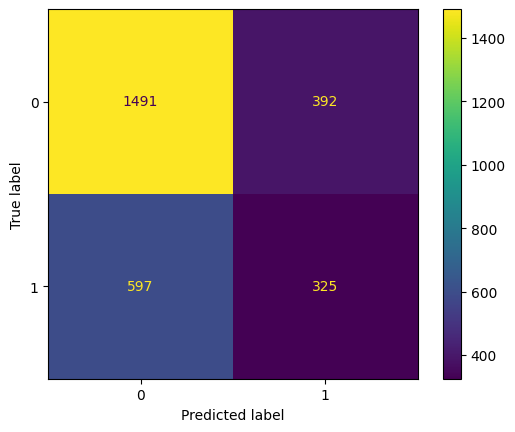

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

test = data_validation_labeled.drop(columns='label')
test_labels = data_validation_labeled.label
best_model = opt.best_estimator_
pred_y_test = best_model.predict(test)

print(f'Accuracy Score is {accuracy_score(test_labels,pred_y_test)}')
cm = confusion_matrix(test_labels, pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [13]:
cm = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

In [14]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred_y_test))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      1883
           1       0.45      0.35      0.40       922

    accuracy                           0.65      2805
   macro avg       0.58      0.57      0.57      2805
weighted avg       0.63      0.65      0.63      2805



In [15]:
classification_report = pd.DataFrame(classification_report(test_labels, pred_y_test,output_dict=True)).transpose()

## Proxy Model creation for PDP-ALE and Counterfactual Explanations

In [16]:
hyperparameters = {'Model__max_depth': (2, 4, 6, 10),
                                'Model__min_child_weight': (1, 3),
                                'Model__learning_rate': [0.001, 0.01, 0.1],
                                'Model__n_estimators': (25, 50, 75 , 100),
                                "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(),RobustScaler()]}

In [17]:
    # proxy model for PDP-ALE
surrogate_model_accuracy = proxy_model(opt.param_grid,opt,'accuracy','XGBoostRegressor')

In [18]:
missclassified = pd.concat([test, test_labels.rename('GroundTruth')], axis=1).reset_index(drop=True)
missclassified['Predicted'] = pred_y_test
missclassified['Label'] = (missclassified['GroundTruth'] != missclassified['Predicted']).astype(int)
missclassified[missclassified['Label']==1]

,dns_interlog_time_q1,dns_interlog_time_q2,dns_interlog_time_q3,dns_interlog_time_q4,dns_interlog_time_q5,ssl_interlog_time_q1,ssl_interlog_time_q2,ssl_interlog_time_q3,ssl_interlog_time_q4,ssl_interlog_time_q5,...,smtp_in_hazardous_extensions,non_working_days_dns,non_working_days_http,non_working_days_ssl,non_working_hours_dns,non_working_hours_http,non_working_hours_ssl,GroundTruth,Predicted,Label
2,22.0,0.0,0.0,0.0,0.0,61.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0,1,1
4,4.0,0.0,0.0,0.0,0.0,127.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.166667,0.166667,0.166667,0,1,1
5,0.0,0.0,0.0,0.0,0.0,97.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1,1
9,21.0,0.0,0.0,0.0,0.0,46.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1,1
10,0.0,0.0,0.0,0.0,0.0,52.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,1
2801,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,1
2802,31.0,0.0,0.0,0.0,0.0,24.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,1
2803,38.0,0.0,0.0,0.0,0.0,56.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,1


In [19]:
missclassified[missclassified['Label']==1].drop(columns='Label').to_csv('misclassified_instances.csv')

In [20]:
pd.read_csv('misclassified_instances.csv',index_col=0)

,dns_interlog_time_q1,dns_interlog_time_q2,dns_interlog_time_q3,dns_interlog_time_q4,dns_interlog_time_q5,ssl_interlog_time_q1,ssl_interlog_time_q2,ssl_interlog_time_q3,ssl_interlog_time_q4,ssl_interlog_time_q5,...,smtp_in_files,smtp_in_hazardous_extensions,non_working_days_dns,non_working_days_http,non_working_days_ssl,non_working_hours_dns,non_working_hours_http,non_working_hours_ssl,GroundTruth,Predicted
2,22.0,0.0,0.0,0.0,0.0,61.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0,1
4,4.0,0.0,0.0,0.0,0.0,127.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.166667,0.166667,0.166667,0,1
5,0.0,0.0,0.0,0.0,0.0,97.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1
9,21.0,0.0,0.0,0.0,0.0,46.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1
10,0.0,0.0,0.0,0.0,0.0,52.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0
2801,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0
2802,31.0,0.0,0.0,0.0,0.0,24.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0
2803,38.0,0.0,0.0,0.0,0.0,56.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0


In [21]:
misclassified_instance = missclassified.drop(columns=['GroundTruth','Label']).loc[5]
train = data_train_test.drop(columns='label')
train_labels = data_train_test.label
# #proxy_model and dataset for counterfactual explanations
# proxy_model , proxy_dataset = instance_proxy(train,train_labels,opt, misclassified_instance,hyperparameters)

In [22]:
query = pd.DataFrame.from_dict(opt.best_params_,orient='index').T


## Create gRPC Client

### Run `python xai_server.py` command on terminal in order to start server

### Compute PDP 1D Plots via gRPC

In [24]:
client = Client()
k = client.get_explanations(explanation_type='hyperparameterExplanation',explanation_method='pdp',model='I2Cat_Phising_model',feature1='Model__learning_rate')

### Compute PDP 2D Plots via gRPC

In [25]:
client = Client()
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,features,xAxis,yAxis,zAxis= client.get_explanations(explanation_type='hyperparameterExplanation',explanation_method='2dpdp',model='I2Cat_Phising_model',feature1='Model__min_child_weight',feature2='Model__max_depth')

### Compute ALE Plots via gRPC

In [26]:
client = Client()
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,features,xAxis,yAxis = client.get_explanations(explanation_type='hyperparameterExplanation',explanation_method='ale',model='I2Cat_Phising_model',feature1='Model__max_depth')

### Counterfactual Explanations via gRPC

In [27]:
client = Client()
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,table_contets = client.get_explanations(explanation_type='hyperparameterExplanation',explanation_method='counterfactuals',model='I2Cat_Phising_model')

## Model Explainability

### PDPlots and 2D PDPlots via gRPC

In [28]:
client = Client()
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,features,xAxis,yAxis,zAxis = client.get_explanations(explanation_type='featureExplanation',explanation_method='pdp',
                                                  model = 'I2Cat_Phising_model', feature1='dns_interlog_time_q1')



## CounterfactualsExplanations via gRPC

In [29]:
client = Client()
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,table_contents = client.get_explanations(explanation_type='featureExplanation',explanation_method='counterfactuals',query=misclassified_instance.to_frame().T.astype(train.dtypes).to_parquet(),model='I2Cat_Phising_model',target='label')

### ALE plots via gRPC

In [30]:
client = Client()
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,features,xAxis,yAxis = client.get_explanations(explanation_type='featureExplanation',explanation_method='ale',
                                                  model = 'I2Cat_Phising_model', feature1='dns_interlog_time_q1')

In [31]:
import grpc
import xai_service_pb2
import xai_service_pb2_grpc

with grpc.insecure_channel('localhost:50051') as channel:
    stub = xai_service_pb2_grpc.ExplanationsStub(channel)
    k = stub.Initialization(xai_service_pb2.InitializationRequest(model_name = 'I2Cat_Phising_model'))

In [32]:
k.feature_explanation.plots

{'pdp': explainability_type: "featureExplanation"
explanation_method: "pdp"
explainability_model: "I2Cat_Phising_model"
plot_name: "Partial Dependece Plot (PDP)"
plot_descr: "PD (Partial Dependence) Plots show how a feature affects a model\'s predictions, holding other features constant, to illustrate feature impact."
plot_type: "LinePLot"
features {
  feature1: "dns_interlog_time_q1"
}
xAxis {
  axis_name: "Feature Values"
  axis_values: "0.0"
  axis_values: "4.515151515151516"
  axis_values: "9.030303030303031"
  axis_values: "13.545454545454547"
  axis_values: "18.060606060606062"
  axis_values: "22.575757575757578"
  axis_values: "27.090909090909093"
  axis_values: "31.60606060606061"
  axis_values: "36.121212121212125"
  axis_values: "40.63636363636364"
  axis_values: "45.151515151515156"
  axis_values: "49.66666666666667"
  axis_values: "54.18181818181819"
  axis_values: "58.6969696969697"
  axis_values: "63.21212121212122"
  axis_values: "67.72727272727273"
  axis_values: "72.24